In [262]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

In [263]:
#Read NO-NO2-NOx Series
dataFrame = pd.read_excel("../data/DataAirTrain.xlsx",index_col= 'time', sheet_name="NO-NO2-NOx")
dataFrame = dataFrame.tail(1000)

In [264]:
dataFrame[['NO','NOx']] = dataFrame[['NO','NOx']].interpolate(method='linear')

In [265]:
#Using linear regression to fill missing data
linearModel = LinearRegression()
dataFrame = dataFrame.copy()
nanMask = dataFrame[['NO2']].isna()
nanMask = nanMask['NO2']

xTrain = dataFrame.loc[~nanMask,['NOx']]
yTrain = dataFrame.loc[~nanMask,['NO2']]

linearModel.fit(xTrain, yTrain)

xTest = dataFrame.loc[nanMask, ['NOx']]
yTest = linearModel.predict(xTest)
dataFrame.loc[nanMask,['NO2']] = yTest

In [266]:
#Fix gap in time index
dataFrame = dataFrame.resample('H').interpolate(method='linear')

In [267]:
from statsmodels.tsa.stattools import adfuller
def stationary(var, desc):
    print(
        f"'{desc}' is stationary: "
        f"{adfuller(var)[0] < adfuller(var)[4]['1%']}."
        f" => p_value {adfuller(var)[1]}")


In [268]:
stationary(dataFrame.NO, 'NO')
stationary(dataFrame.NO2, 'NO2')
stationary(dataFrame.NOx, 'NOx')
stationary(dataFrame.NO.diff().dropna(), 'NO_diff')
stationary(dataFrame.NO2.diff().dropna(), 'NO2_diff')
stationary(dataFrame.NOx.diff().dropna(), 'NOx_diff')

'NO' is stationary: True. => p_value 5.0344450918280766e-12
'NO2' is stationary: False. => p_value 0.5102010057695567
'NOx' is stationary: False. => p_value 0.12360516108353725
'NO_diff' is stationary: True. => p_value 1.4186204190325697e-19
'NO2_diff' is stationary: True. => p_value 5.654248634382335e-21
'NOx_diff' is stationary: True. => p_value 1.7473332113661512e-19


In [269]:
trainSet = dataFrame[: -48]
testSet = dataFrame[-48: ]
dataFrame = trainSet
dataFrame = dataFrame.diff().dropna()
print(dataFrame)

                       NO        NO2     NOx
time                                        
2019-07-25 04:00:00 -2.21  -9.280000  -8.088
2019-07-25 05:00:00 -3.49 -23.330000 -18.312
2019-07-25 06:00:00 -0.06   0.690000   0.384
2019-07-25 07:00:00  0.08   2.850000   1.908
2019-07-25 08:00:00  1.57   8.590000   6.996
...                   ...        ...     ...
2019-09-03 02:00:00  0.05   0.046301   0.048
2019-09-03 03:00:00  0.02  -0.023151  -0.024
2019-09-03 04:00:00  0.06  -0.011575  -0.012
2019-09-03 05:00:00  0.06   0.011575   0.012
2019-09-03 06:00:00 -0.03   0.173630   0.180

[963 rows x 3 columns]


In [271]:
from statsmodels.tsa.api import VAR
model = VAR(dataFrame)
sorted_order = model.select_order(40)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        9.195       9.211       9849.       9.201
1        8.129       8.191       3390.       8.153
2        7.970       8.080       2892.       8.012
3        7.878       8.035       2638.       7.938
4        7.824       8.028       2500.       7.902
5        7.771      8.022*       2371.       7.867
6        7.728       8.026       2271.      7.842*
7        7.733       8.079       2283.       7.865
8        7.715       8.107       2242.       7.865
9        7.709       8.148       2228.       7.876
10       7.706       8.192       2222.       7.892
11       7.704       8.238       2217.       7.908
12       7.707       8.287       2224.       7.928
13       7.712       8.340       2236.       7.952
14       7.707       8.381       2223.       7.964
15       7.708       8.430       2227.       7.983
16       7.712       8.481     

In [272]:
lag = sorted_order.aic
results = model.fit(lag)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, Mar, 2023
Time:                     23:30:50
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    9.00291
Nobs:                     933.000    HQIC:                   8.12706
Log likelihood:          -7238.02    FPE:                    1976.40
AIC:                      7.58717    Det(Omega_mle):         1494.93
--------------------------------------------------------------------
Results for equation NO
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.050249         0.163814            0.307           0.759
L1.NO          -0.952342         0.153761           -6.194           0.000
L1.NO2         -0.488582         0.080730           -6.052           0.000
L1.NOx      

In [273]:
step = 48
dateTimeIndex = pd.date_range(dataFrame.index[-1] + pd.DateOffset(hours=1), periods=step, freq="H")

predictions = results.forecast(dataFrame.values[-lag :], steps = step)

dataFramePredicted = pd.DataFrame({'time':dateTimeIndex, 'NO':predictions[:,0], 'NO2':predictions[:,1], 'NOx':predictions[:,2]})
dataFramePredicted = dataFramePredicted.set_index('time')

dataFramePredicted =  trainSet.iloc[-1] + dataFramePredicted.cumsum(axis=0)
print(dataFramePredicted)



                           NO       NO2       NOx
time                                             
2019-09-03 07:00:00  2.337210  7.543709  2.895964
2019-09-03 08:00:00  2.986624  7.631154  5.316857
2019-09-03 09:00:00  2.682812  7.696315  5.420021
2019-09-03 10:00:00  3.263018  7.199999  5.380030
2019-09-03 11:00:00  7.795498  6.223893  8.971383
2019-09-03 12:00:00  6.155000  5.895221  5.079417
2019-09-03 13:00:00  3.306883  2.708924  0.127610
2019-09-03 14:00:00  3.568446  1.796510 -0.895765
2019-09-03 15:00:00  4.369282  1.193583 -1.173173
2019-09-03 16:00:00  2.711542  0.016867 -3.256636
2019-09-03 17:00:00  1.703215  1.937846 -2.565061
2019-09-03 18:00:00  0.926578  3.106560 -2.279892
2019-09-03 19:00:00  0.690474  4.229670 -1.197577
2019-09-03 20:00:00  1.114614  6.603100  0.917029
2019-09-03 21:00:00  0.258774  7.567362  0.665096
2019-09-03 22:00:00 -0.899561  6.692598 -1.476193
2019-09-03 23:00:00  1.704131  6.477348  0.789217
2019-09-04 00:00:00  3.670519  6.822362  2.759693


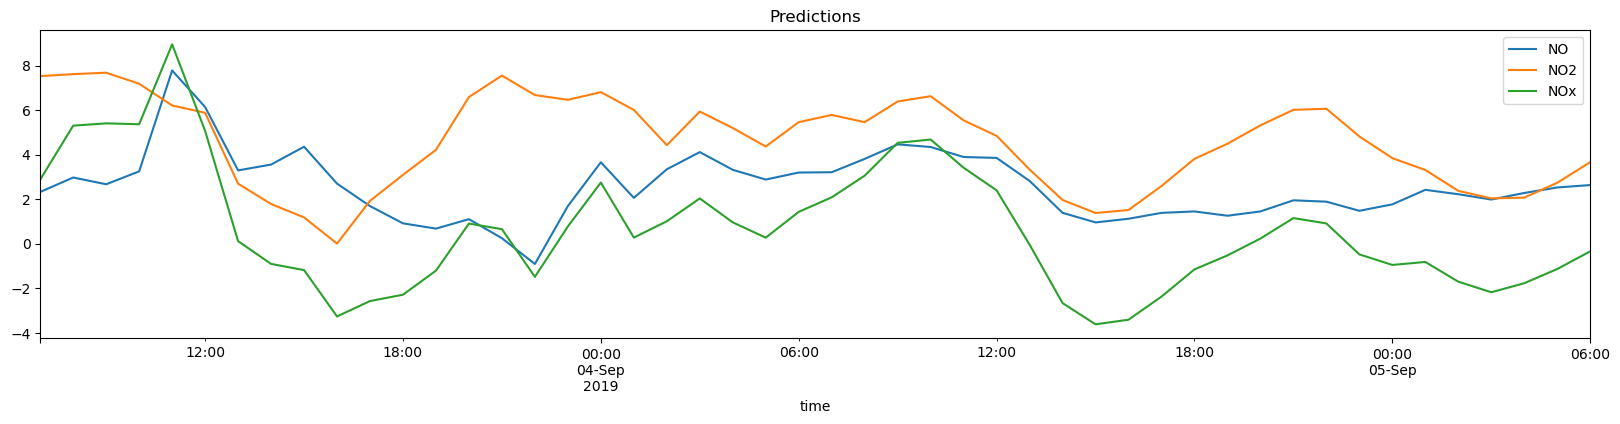

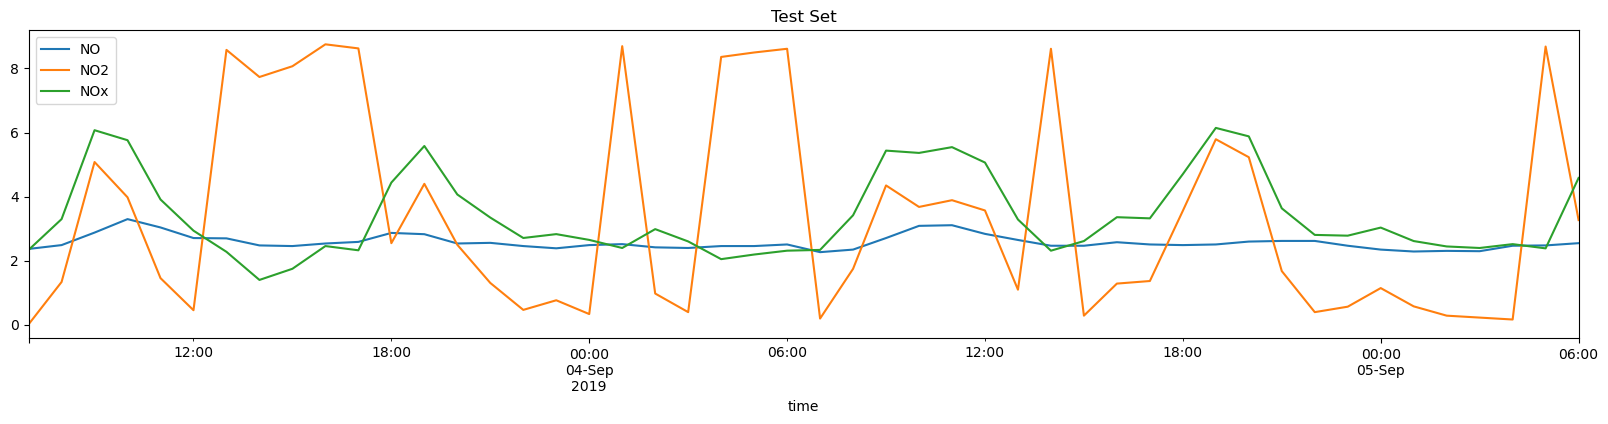

In [274]:
predictNOFig = dataFramePredicted.plot(figsize=(20,4), title='Predictions')
testFig = testSet.plot(figsize=(20,4), title='Test Set')
figure = predictNOFig.get_figure()    
figure.savefig(f'../figure/predictNOFig.png',bbox_inches ="tight")
figure = testFig.get_figure()    
figure.savefig(f'../figure/testFig.png',bbox_inches ="tight")

In [275]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
tmp = []
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,0], testSet.iloc[:,0]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,1], testSet.iloc[:,1]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,2], testSet.iloc[:,2]))
metric = pd.DataFrame(tmp,index=dataFramePredicted.columns.values)
print(metric)

          mape        me       mae        mpe      rmse      corr    minmax
NO    0.412604  0.012864  1.074393  -0.001997  1.426473  0.323430  0.332177
NO2  11.779826  1.155446  3.704570  11.474670  4.346288 -0.289835  0.619543
NOx   1.016330 -2.743338  3.154976  -0.895065  3.738610  0.373941  0.988936


C:\Users\admin\AppData\Local\Temp\ipykernel_992\3187061451.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\admin\AppData\Local\Temp\ipykernel_992\3187061451.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\admin\AppData\Local\Temp\ipykernel_992\3187061451.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\admin\AppData\Local\Temp\ipykernel_992\3187061451.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, Non